# Exploration of final results

In [90]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import alphashape
from shapely.geometry import Polygon

from spectroscopy.src.common.constants import ELEMENT_TYPES, ELEMENT_WEIGHTS
from spectroscopy.src.postprocessing.compare_metrics import CompareMetrics
from spectroscopy.src.common.utility_functions import get_working_directory

dir = get_working_directory()
results_path = f'{dir}/reports/results/'
plots_path = f'{results_path}/plots/'

### Initial preparation of df and long df (dfl) dataframes

In [91]:
df = pd.read_csv(f'{results_path}results_final.csv')
df['type'] = df['element'].apply(lambda x: ELEMENT_TYPES[x])
df['neg_rmse'] = -df['rmse']
df['wrmse'] = df.apply(lambda row: row['rmse'] * ELEMENT_WEIGHTS[row['element']], axis=1)
df['neg_wrmse'] = -df['wrmse']
df.head()

,model,sample_mode,element,unit,r2,mse,rmse,rrmse,mae,mape,wrmse,type,neg_rmse,neg_wrmse
0,MLR,Dried,Al,ppm,0.2869,0.0057,0.0755,0.0168,0.0619,1.303000e-01,0.10570,micro,-0.0755,-0.10570
1,MLR,Dried,B,ppm,0.5825,0.0046,0.0676,0.0160,0.0485,2.017760e+13,0.05408,micro,-0.0676,-0.05408
2,MLR,Dried,Ca,pct,0.3315,0.0081,0.0898,0.0215,0.0704,1.797000e-01,0.12572,macro,-0.0898,-0.12572
3,MLR,Dried,Cu,ppm,0.3391,0.0124,0.1113,0.0252,0.0818,6.392910e+13,0.15582,micro,-0.1113,-0.15582
4,MLR,Dried,Fe,ppm,0.1521,0.0110,0.1050,0.0235,0.0750,2.280910e+13,0.14700,micro,-0.1050,-0.14700


In [92]:
# Creating a long format df
m_cols = ['r2','rmse', 'neg_rmse', 'wrmse', 'neg_wrmse']
i_cols = ['model','sample_mode','element','unit','type']
dfl = pd.melt(df, id_vars=i_cols, value_vars=m_cols, var_name='metric', value_name='score')

In [93]:
# Set consistent colours for dried/fresh samples
colours = {'Dried':'C1','Fresh':'C0'}

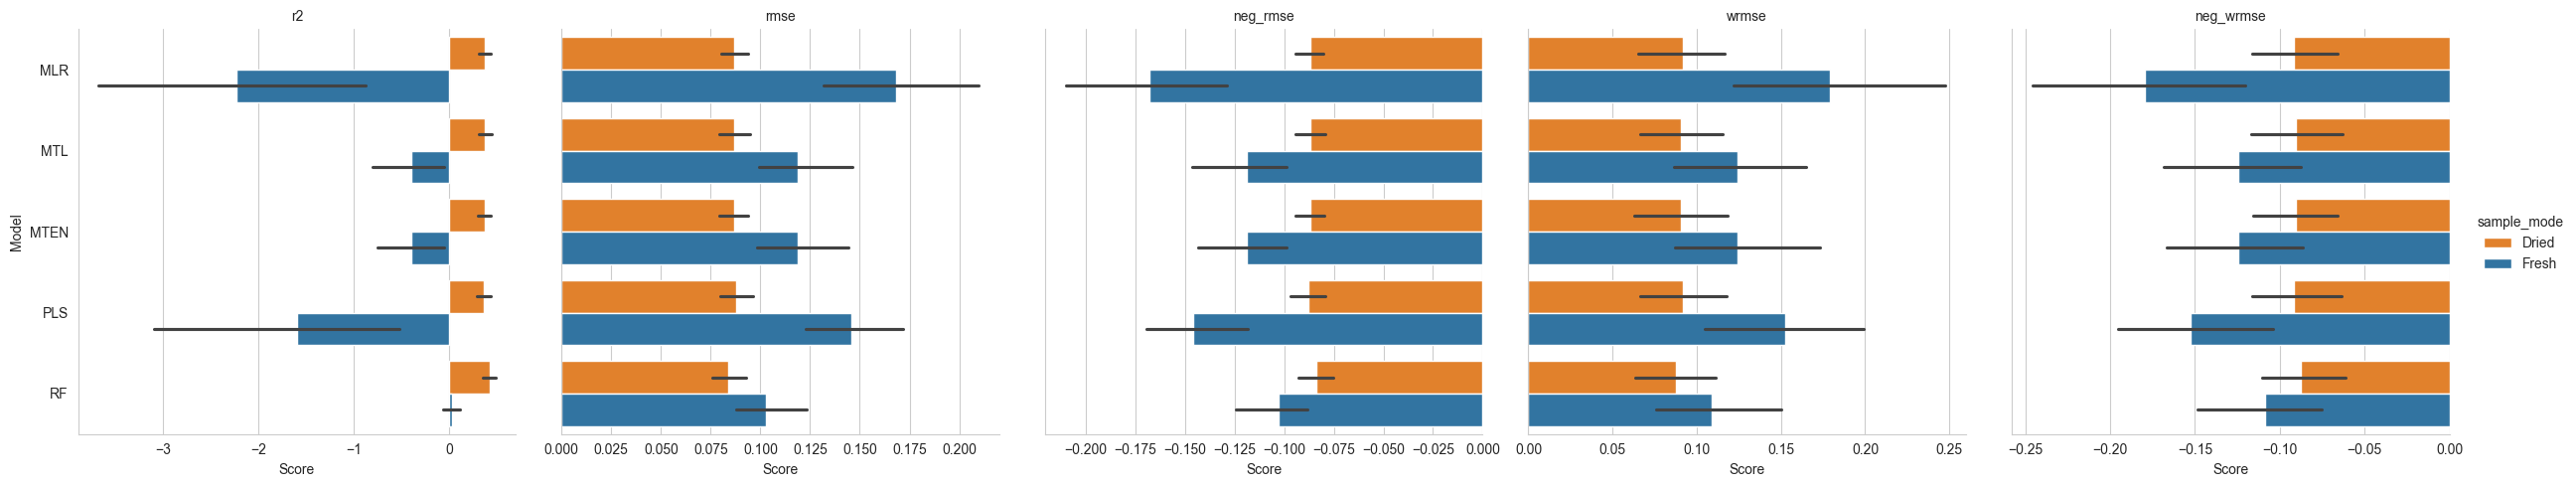

In [94]:
# Visualising what
g = sns.catplot(
    data=dfl,
    x='score',
    y='model',
    hue='sample_mode',
    col='metric',
    kind='bar',
    orient='h',
    height=5,
    aspect=1,
    dodge=True,
    sharex=False,
    palette=colours
)

g.set_axis_labels('Score', 'Model')
g.set_titles('{col_name}')
plt.show()

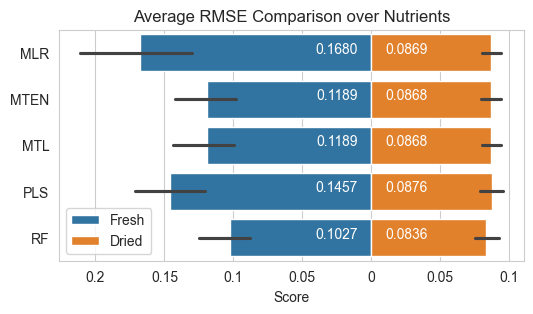

In [95]:
df_rmse = (dfl[dfl['metric']=='rmse'].
           pivot(index=['model','element'], columns='sample_mode', values='score'))

df_rmse['Fresh'] = -df_rmse['Fresh']

def add_values(axis):
    for p in axis.patches:
        w = p.get_width()
        ha = 'left' if w > 0 else 'right'
        hp = 0.01 if w > 0 else -0.01
        axis.annotate(
            f'{w if w > 0 else -w:.4f}',
            (hp, p.get_y() + p.get_height() / 1.7),
            ha=ha,
            va='bottom',
            color='white'
        )

fig, ax = plt.subplots(figsize=(6,3))
ax1 = sns.barplot(df_rmse, x='Fresh', y='model', label='Fresh')
ax2 = sns.barplot(df_rmse, x='Dried', y='model', label='Dried')
ax1.set_title('Fresh')
plt.title('Average RMSE Comparison over Nutrients')
plt.xlabel('Score')
plt.ylabel(None)
plt.xticks(ticks=[-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1], labels=['0.2', '0.15', '0.1', '0.05', '0', '0.05', '0.1'])
add_values(ax1)
plt.show()

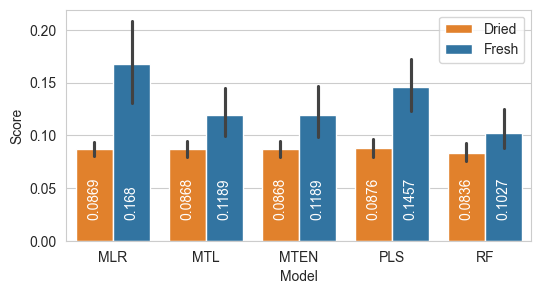

In [96]:
_, ax = plt.subplots(figsize=(6,3))
sns.barplot(dfl[dfl['metric']=='rmse'], x='model', y='score', hue='sample_mode', ax=ax, palette=colours)

for p in ax.patches:
    if p.get_width() == 0:
        continue
    h = p.get_height()
    xval = p.get_x() + p.get_width()/2
    ax.text(xval, 0.02, round(h, 4), ha='center', va='bottom', rotation=90, color='white')

#plt.title('Model Score - Dried/Fresh Combined')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title=None)
plt.savefig(f'{plots_path}/Ave_RMSE_Comparison_Plot.png', dpi=400, bbox_inches='tight')
plt.show()



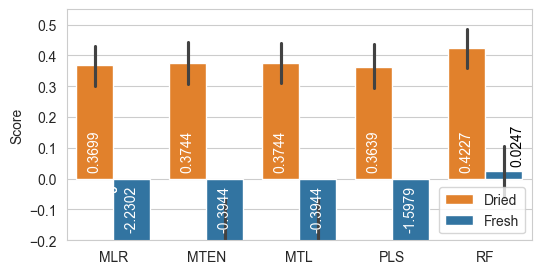

In [97]:
_, ax = plt.subplots(figsize=(6,3))
sns.barplot(dfl[dfl['metric']=='r2'].sort_values(['model','sample_mode']), x='model', y='score', hue='sample_mode', ax=ax, palette=colours)

for i, p in enumerate(ax.patches):
    colour = 'white'
    yval = 0.02
    va = 'bottom'
    h = p.get_height()
    xval = p.get_x() + p.get_width()/2
    if i > 4:
        va = 'top'
        yval = -0.02
    if i == 9:
        xval = p.get_x() + p.get_width()/2 + 0.15
        colour = 'black'
        va = 'bottom'
        yval = 0.04
    ax.text(xval, yval, round(h, 4), ha='center', va=va, rotation=90, color=colour)

#plt.title('Model Score - Dried/Fresh Combined')
plt.ylim(-0.2,0.55)
plt.xlabel(None)
plt.ylabel('Score')
plt.legend(title=None, loc='lower right')
plt.show()

In [98]:
dfl.groupby(['model','sample_mode','metric']).agg({'score':'mean'}).query('metric=="rmse"')

score
model sample_mode metric          
MLR   Dried       rmse    0.086931
      Fresh       rmse    0.168031
MTEN  Dried       rmse    0.086785
      Fresh       rmse    0.118915
MTL   Dried       rmse    0.086785
      Fresh       rmse    0.118915
PLS   Dried       rmse    0.087615
      Fresh       rmse    0.145715
RF    Dried       rmse    0.083638
      Fresh       rmse    0.102708

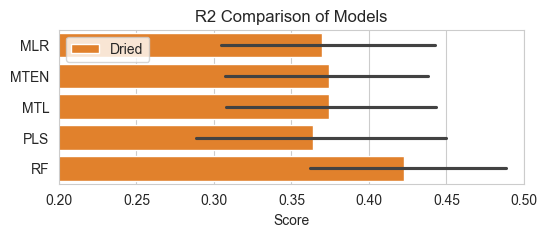

In [99]:
df_r2 = (dfl[dfl['metric']=='r2'].
           pivot(index=['model','element'], columns='sample_mode', values='score'))

_, ax = plt.subplots(figsize=(6,2))
sns.barplot(df_r2, x='Dried', y='model', label='Dried', dodge=True, color='C1', ax=ax)
plt.title('R2 Comparison of Models')
plt.xlabel('Score')
plt.xlim(0.2,0.5)
plt.ylabel(None)
for p in ax1.patches:
        w = p.get_width()
        ax1.annotate(
            f'{w:.4f}',
            (0.22, p.get_y() + p.get_height() / 1.7),
            ha='left',
            va='bottom',
            color='white'
        )
plt.show()

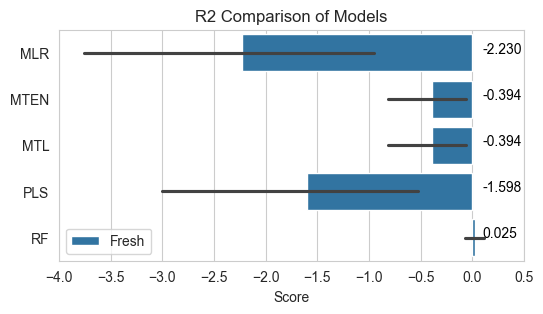

In [100]:
fig, ax = plt.subplots(figsize=(6,3))
ax1 = sns.barplot(df_r2, x='Fresh', y='model', label='Fresh', dodge=True, color='C0')
plt.title('R2 Comparison of Models')
plt.xlabel('Score')
plt.xlim(-4,0.5)
plt.ylabel(None)
for p in ax1.patches:
        w = p.get_width()
        ax1.annotate(
            f'{w:.3f}',
            (0.1, p.get_y() + p.get_height() / 1.7),
            ha='left',
            va='bottom',
            color='black'
        )
plt.show()

# Micro/Macro Nutirent Analysis

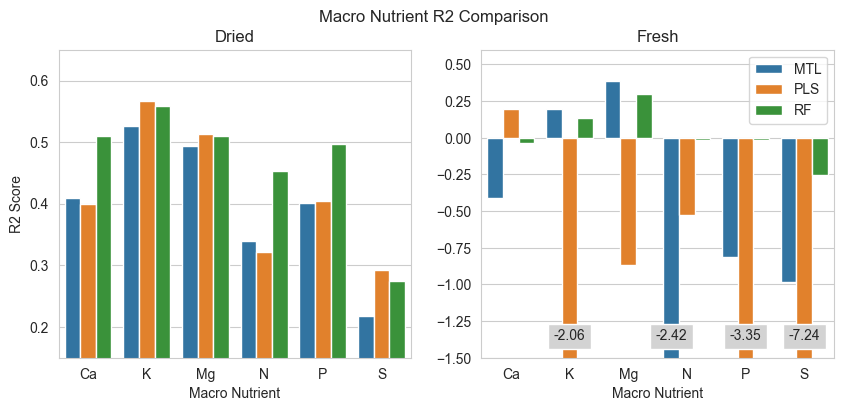

In [101]:
df_mv_r2 = (dfl[(~dfl['model'].isin(['MLR','MTEN'])) & (dfl['metric']=='r2')].
            pivot(index=['type','element','model'], columns='sample_mode', values='score').
            reset_index().
            sort_values(by=['type','element','model']))

fig, ax = plt.subplots(figsize=(10,4), ncols=2)
sns.barplot(data=df_mv_r2[df_mv_r2['type']=='macro'], x='element', y='Dried', hue='model', ax=ax[0], legend=False)
sns.barplot(data=df_mv_r2[df_mv_r2['type']=='macro'], x='element', y='Fresh', hue='model', ax=ax[1])

def add_vals_off_plot(ax):
    for a in ax:
        for p in a.patches:
            h = p.get_height()
            if h < y_min:
                xval = p.get_x() + p.get_width()/2
                a.text(xval, y_min+0.1, round(h, 2), ha='center', va='bottom',
                       bbox=dict(facecolor='lightgrey'))

y_min = -1.5
add_vals_off_plot(ax)

fig.suptitle('Macro Nutrient R2 Comparison')
ax[0].set_title('Dried')
ax[1].set_title('Fresh')
ax[0].set_ylabel('R2 Score')
ax[1].set_ylabel(None)
ax[0].set_xlabel('Macro Nutrient')
ax[1].set_xlabel('Macro Nutrient')
ax[0].set_ylim(0.15,0.65)
ax[1].set_ylim(y_min,0.6)
ax[1].legend(title=None)
plt.show()

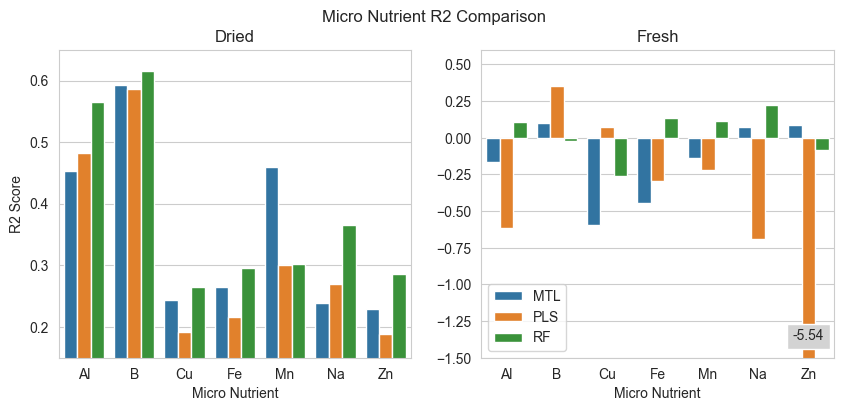

In [102]:
fig, ax = plt.subplots(figsize=(10,4), ncols=2)
sns.barplot(data=df_mv_r2[df_mv_r2['type']=='micro'], x='element', y='Dried', hue='model', ax=ax[0], legend=False)
sns.barplot(data=df_mv_r2[df_mv_r2['type']=='micro'], x='element', y='Fresh', hue='model', ax=ax[1])

add_vals_off_plot(ax)

fig.suptitle('Micro Nutrient R2 Comparison')
ax[0].set_title('Dried')
ax[1].set_title('Fresh')
ax[1].set_ylabel(None)
ax[0].set_ylabel('R2 Score')
ax[0].set_xlabel('Micro Nutrient')
ax[1].set_xlabel('Micro Nutrient')
ax[0].set_ylim(0.15,0.65)
ax[1].set_ylim(y_min,0.6)
ax[1].legend(title=None)
plt.show()

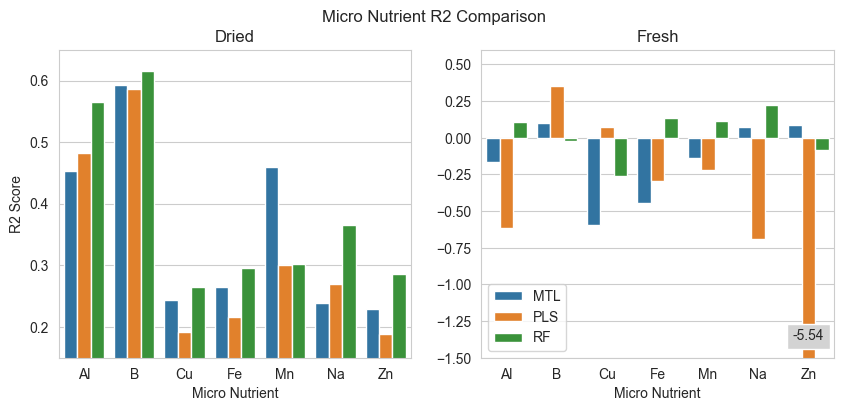

In [103]:
fig, ax = plt.subplots(figsize=(10,4), ncols=2)
sns.barplot(data=df_mv_r2[df_mv_r2['type']=='micro'], x='element', y='Dried', hue='model', ax=ax[0], legend=False)
sns.barplot(data=df_mv_r2[df_mv_r2['type']=='micro'], x='element', y='Fresh', hue='model', ax=ax[1])

add_vals_off_plot(ax)

fig.suptitle('Micro Nutrient R2 Comparison')
ax[0].set_title('Dried')
ax[1].set_title('Fresh')
ax[1].set_ylabel(None)
ax[0].set_ylabel('R2 Score')
ax[0].set_xlabel('Micro Nutrient')
ax[1].set_xlabel('Micro Nutrient')
ax[0].set_ylim(0.15,0.65)
ax[1].set_ylim(y_min,0.6)
ax[1].legend(title=None)
plt.show()

# Baseline Correction Improvement
### MLR baseline

In [104]:
def make_df_improvement(df, metric):
    new_df = (df[df['metric']==metric].
           pivot(index=['sample_mode','element'], columns='preprocessing', values='score')).copy()
    new_df['improvement'] = new_df['Not Processed'] - new_df['Baseline Corrected']
    if metric == 'r2':
        new_df['improvement'] = -new_df['improvement']
    new_df.drop(columns=['Baseline Corrected','Not Processed'], inplace=True)
    return new_df

bi_cols = ['preprocessing','element','sample_mode']
df_bl = pd.read_csv(f'{results_path}/mlr/mlr_baseline_pre_post_baseline_correction_results.csv', usecols=bi_cols+['r2', 'rmse'])
df_bl_long = df_bl.melt(id_vars=bi_cols, value_vars=['r2', 'rmse'], var_name='metric', value_name='score')

df_bl_rmse = make_df_improvement(df_bl_long, 'rmse')
df_bl_r2 = make_df_improvement(df_bl_long, 'r2')

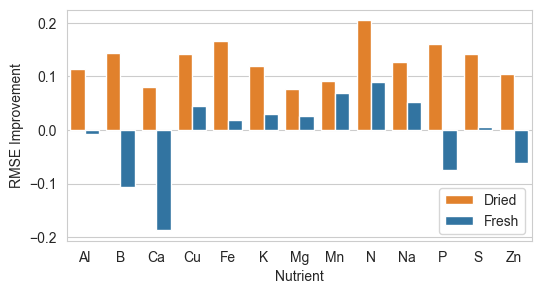

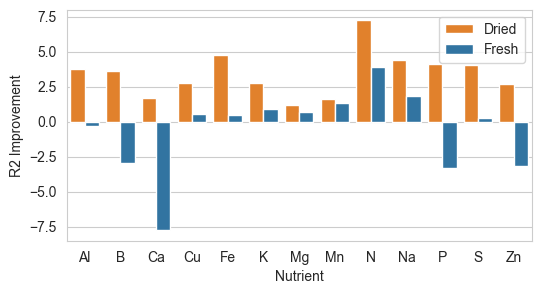

In [105]:
def plot_improvement(df, metric, model):
    _, ax = plt.subplots(figsize=(6,3))
    sns.barplot(df, x='element', y='improvement', hue='sample_mode', legend=True, ax=ax, palette=colours)
    plt.xlabel('Nutrient')
    plt.ylabel(f'{metric} Improvement')
    plt.legend(title=None)
    plt.savefig(f'{plots_path}/{model}_{metric}_Baseline_Correction_Improvement.png', dpi=400, bbox_inches='tight')
    plt.show()

plot_improvement(df_bl_rmse, 'RMSE', 'MLR')
plot_improvement(df_bl_r2, 'R2', 'MLR')

In [106]:
df_bl[df_bl['preprocessing']=='Not Processed'].groupby(['sample_mode']).agg({'r2':'mean', 'rmse':'mean'})

,r2,rmse
sample_mode,,
Dried,-3.060869,0.215200
Fresh,-1.654962,0.160115


In [107]:
df_bl[df_bl['preprocessing']=='Baseline Corrected'].groupby(['sample_mode']).agg({'r2':'mean', 'rmse':'mean'})

,r2,rmse
sample_mode,,
Dried,0.369908,0.086931
Fresh,-2.230162,0.168031


### Multi Task Lasso

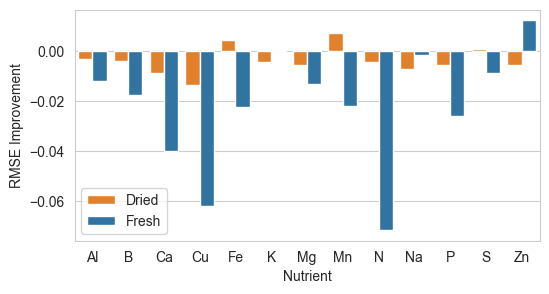

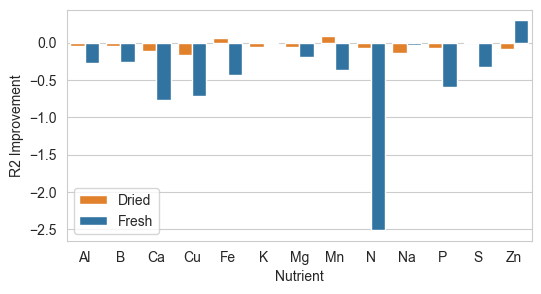

In [108]:
df_mtl = pd.read_csv(f'{results_path}/mtlasso/mtl_pre_post_baseline_correction_results.csv', usecols=bi_cols+['r2', 'rmse'])
df_mtl_long = df_mtl.melt(id_vars=bi_cols, value_vars=['r2', 'rmse'], var_name='metric', value_name='score')

df_mtl_rmse = make_df_improvement(df_mtl_long, 'rmse')
df_mtl_r2 = make_df_improvement(df_mtl_long, 'r2')

plot_improvement(df_mtl_rmse, 'RMSE', 'MTL')
plot_improvement(df_mtl_r2, 'R2', 'MTL')

### PLS Regression

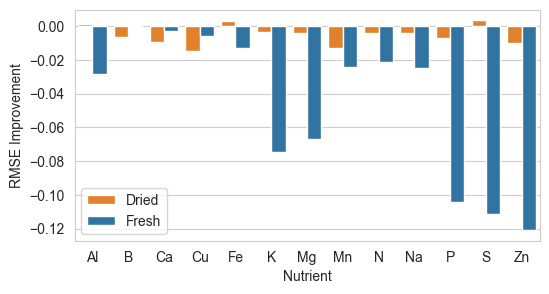

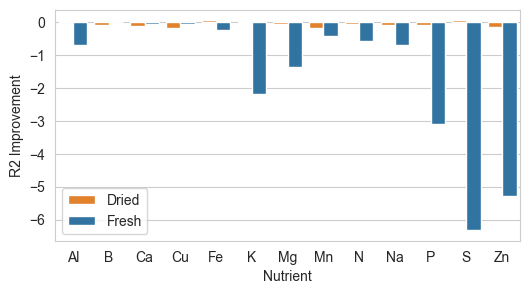

In [109]:
df_pls = pd.read_csv(f'{results_path}/pls/pls_pre_post_baseline_correction_results.csv', usecols=bi_cols+['r2', 'rmse'])
df_pls_long = df_pls.melt(id_vars=bi_cols, value_vars=['r2', 'rmse'], var_name='metric', value_name='score')

df_pls_rmse = make_df_improvement(df_pls_long, 'rmse')
df_pls_r2 = make_df_improvement(df_pls_long, 'r2')

plot_improvement(df_pls_rmse, 'RMSE', 'PLS')
plot_improvement(df_pls_r2, 'R2', 'PLS')

In [110]:
print(df_pls.head(5))
print(df_pls.groupby(['preprocessing','sample_mode']).agg({'r2':'mean', 'rmse':'mean'}))

  element sample_mode       preprocessing      r2    rmse
0      Al       Dried  Baseline Corrected  0.4826  0.0643
1       B       Dried  Baseline Corrected  0.5856  0.0674
2      Ca       Dried  Baseline Corrected  0.3991  0.0851
3      Cu       Dried  Baseline Corrected  0.1923  0.1231
4      Fe       Dried  Baseline Corrected  0.2157  0.1010
                                      r2      rmse
preprocessing      sample_mode                    
Baseline Corrected Dried        0.363900  0.087615
                   Fresh       -1.597862  0.145715
Not Processed      Dried        0.431369  0.082485
                   Fresh        0.018454  0.099854


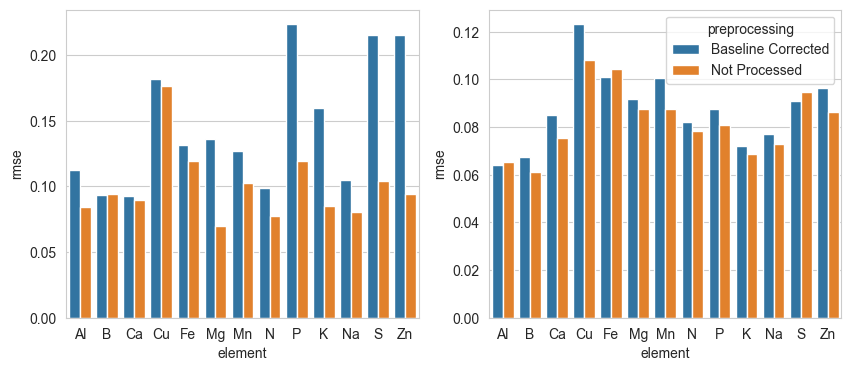

In [111]:
fig, ax = plt.subplots(figsize=(10,4), ncols=2)
sns.barplot(data=df_pls.query('sample_mode=="Fresh"'), x='element', y='rmse', hue='preprocessing', ax=ax[0], legend=False)
sns.barplot(data=df_pls.query('sample_mode=="Dried"'), x='element', y='rmse', hue='preprocessing', ax=ax[1])
plt.show()

In [112]:
# Particularly worsened elements
e = ['Mg','P','K','S','Zn']
df_pls_compare = (df_pls.
                    drop(columns=['r2']).
                    query('(element in @e)').
                    pivot(index=['element', 'sample_mode'], columns=['preprocessing'], values='rmse')
                  )
df_pls_compare.head(5)

preprocessing        Baseline Corrected  Not Processed
element sample_mode                                   
K       Dried                    0.0719         0.0688
        Fresh                    0.1598         0.0852
Mg      Dried                    0.0916         0.0875
        Fresh                    0.1365         0.0699
P       Dried                    0.0877         0.0810

In [113]:
# Look at Fresh first
def pct_increase(row):
    return (row['Baseline Corrected'] - row['Not Processed']) / row['Not Processed'] * 100

df_pls_compare_fresh = (df_pls_compare.
                        query('sample_mode=="Fresh"').
                        reset_index().
                        drop(columns=['sample_mode']).
                        set_index('element'))
df_pls_compare_fresh['diff'] = df_pls_compare_fresh.apply(lambda row: pct_increase(row), axis=1)

# Now added with % increase in RMSE
print(df_pls_compare_fresh.head(5))

print(f'Average increase in RMSE over {e}: {df_pls_compare_fresh['diff'].mean():.2f}')


preprocessing  Baseline Corrected  Not Processed        diff
element                                                     
K                          0.1598         0.0852   87.558685
Mg                         0.1365         0.0699   95.278970
P                          0.2235         0.1195   87.029289
S                          0.2156         0.1040  107.307692
Zn                         0.2153         0.0943  128.313892
Average increase in RMSE over ['Mg', 'P', 'K', 'S', 'Zn']: 101.10


In [114]:
(df_pls_compare.
 query('sample_mode=="Dried"').
 reset_index().drop(columns=['sample_mode']).
 describe().loc['mean':'mean'].
 apply(lambda row: pct_increase(row), axis=1))

mean    4.802867
dtype: float64

### Random Forest

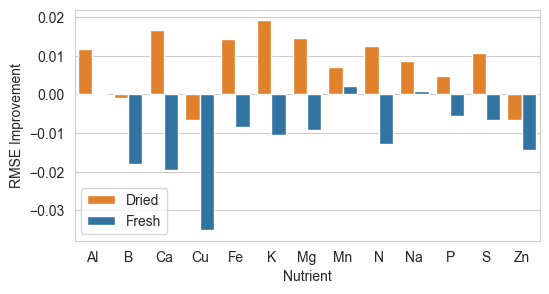

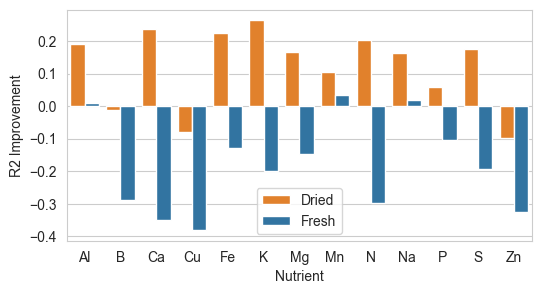

In [115]:
bi_cols = ['preprocessing','element','sample_mode']
df_rf = pd.read_csv(f'{results_path}/randforest/rf_pre_post_baseline_correction_results.csv', usecols=bi_cols+['r2', 'rmse'])
df_rf_long = df_rf.melt(id_vars=bi_cols, value_vars=['r2', 'rmse'], var_name='metric', value_name='score')

df_rf_rmse = make_df_improvement(df_rf_long, 'rmse')
df_rf_r2 = make_df_improvement(df_rf_long, 'r2')

plot_improvement(df_rf_rmse, 'RMSE', 'RF')
plot_improvement(df_rf_r2, 'R2', 'RF')

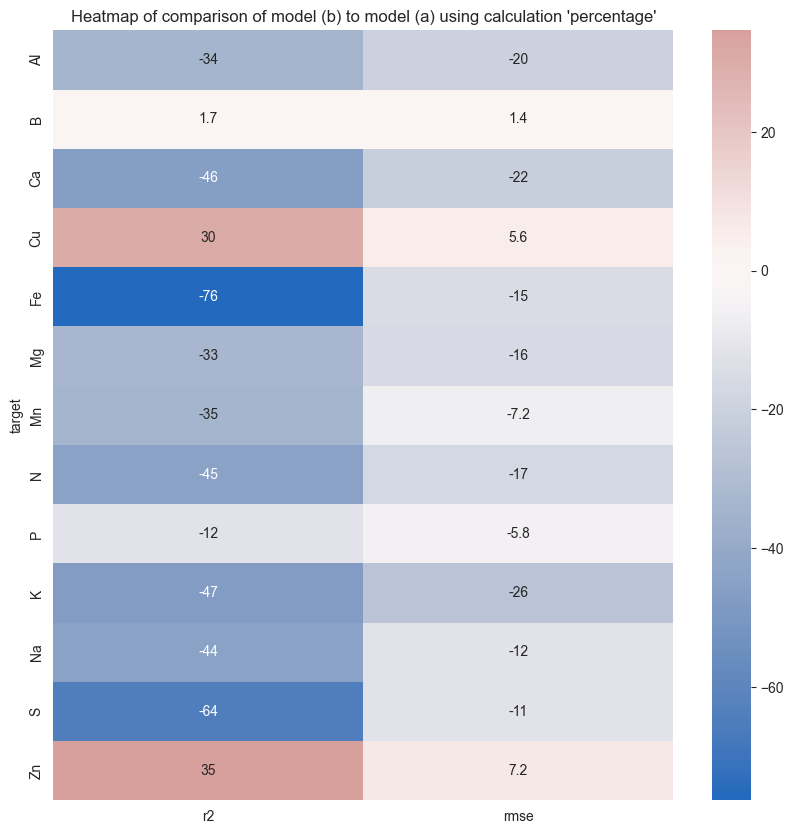

In [116]:
proc_dried_result = df_rf.query('(preprocessing=="Baseline Corrected") and (sample_mode=="Dried")').rename(columns={'element':'target'}).set_index('target').drop(columns=['preprocessing','sample_mode'])
proc_fresh_result = df_rf.query('(preprocessing=="Baseline Corrected") and (sample_mode=="Fresh")').rename(columns={'element':'target'}).set_index('target').drop(columns=['preprocessing','sample_mode'])

non_proc_dried_result = df_rf.query('(preprocessing=="Not Processed")  and (sample_mode=="Dried")').rename(columns={'element':'target'}).set_index('target').drop(columns=['preprocessing','sample_mode'])
non_proc_fresh_result = df_rf.query('(preprocessing=="Not Processed")  and (sample_mode=="Fresh")').rename(columns={'element':'target'}).set_index('target').drop(columns=['preprocessing','sample_mode'])

cm = CompareMetrics(proc_dried_result, non_proc_dried_result)

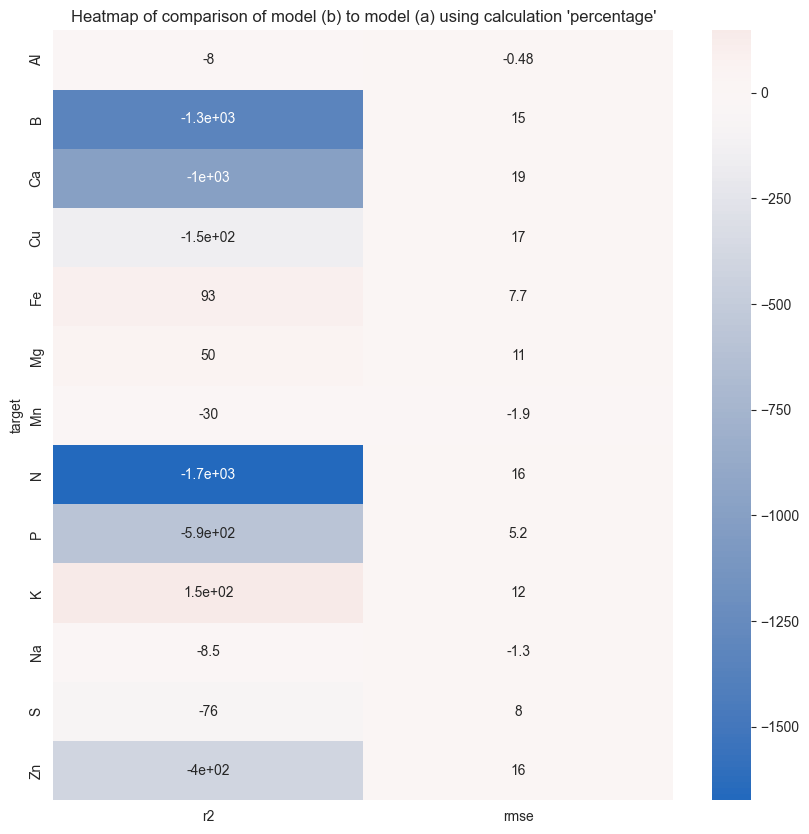

In [117]:
cm = CompareMetrics(proc_fresh_result, non_proc_fresh_result)

In [118]:
df_rf.groupby(['preprocessing', 'sample_mode']).agg({'r2': 'mean', 'rmse': 'mean'})

r2      rmse
preprocessing      sample_mode                    
Baseline Corrected Dried        0.422692  0.083638
                   Fresh        0.024715  0.102708
Not Processed      Dried        0.299608  0.091823
                   Fresh        0.205600  0.092192

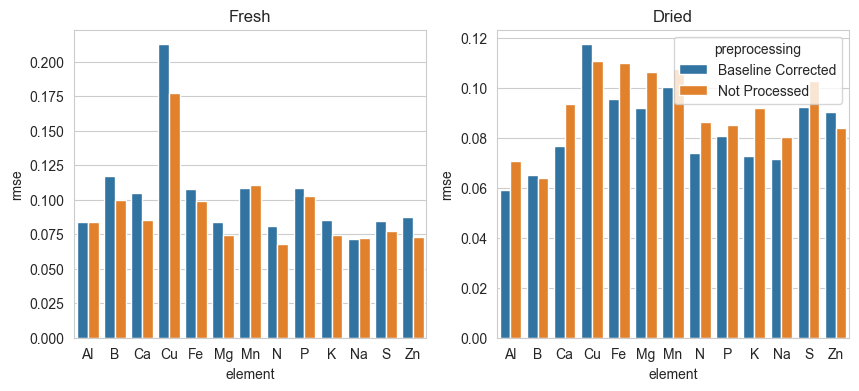

In [119]:

fig, ax = plt.subplots(figsize=(10, 4), ncols=2)
sns.barplot(data=df_rf.query('sample_mode=="Fresh"'), x='element', y='rmse', hue='preprocessing', ax=ax[0],
            legend=False)

sns.barplot(data=df_rf.query('sample_mode=="Dried"'), x='element', y='rmse', hue='preprocessing', ax=ax[1])
ax[0].title.set_text('Fresh')
ax[1].title.set_text('Dried')
plt.show()

In [120]:
df_rf_compare = (df_rf.
                    drop(columns=['r2']).
                    pivot(index=['element', 'sample_mode'], columns=['preprocessing'], values='rmse')
                  )

In [121]:
def pct_increase(row):
    return (row['Baseline Corrected'] - row['Not Processed']) / row['Not Processed'] * 100

df_rf_compare_fresh = (df_rf_compare.
                        query('sample_mode=="Fresh"').
                        reset_index().
                        drop(columns=['sample_mode']).
                        set_index('element'))
df_rf_compare_fresh['diff'] = df_rf_compare_fresh.apply(lambda row: pct_increase(row), axis=1)

df_rf_compare_dried = (df_rf_compare.
                        query('sample_mode=="Dried"').
                        reset_index().
                        drop(columns=['sample_mode']).
                        set_index('element'))
df_rf_compare_dried['diff'] = df_rf_compare_dried.apply(lambda row: pct_increase(row), axis=1)

# Now added with % increase in RMSE
print(df_rf_compare_fresh)
rf_fresh_diff_mean = df_rf_compare_fresh['diff'].mean()
rf_dried_diff_mean = df_rf_compare_dried['diff'].mean()
print(f'Average fresh increase in RMSE: {rf_fresh_diff_mean:.2f}')
print(f'Average dried increase in RMSE: {rf_dried_diff_mean:.2f}')

preprocessing  Baseline Corrected  Not Processed       diff
element                                                    
Al                         0.0836         0.0840  -0.476190
B                          0.1174         0.0995  17.989950
Ca                         0.1050         0.0855  22.807018
Cu                         0.2125         0.1774  19.785795
Fe                         0.1075         0.0992   8.366935
K                          0.0850         0.0745  14.093960
Mg                         0.0838         0.0745  12.483221
Mn                         0.1084         0.1105  -1.900452
N                          0.0806         0.0678  18.879056
Na                         0.0714         0.0723  -1.244813
P                          0.1082         0.1026   5.458090
S                          0.0842         0.0775   8.645161
Zn                         0.0876         0.0732  19.672131
Average fresh increase in RMSE: 11.12
Average dried increase in RMSE: -8.84


In [122]:
from scipy.stats import ttest_ind

res_fresh = ttest_ind(df_rf_compare_fresh['Not Processed'], df_rf_compare_fresh['Baseline Corrected'])
res_dried = ttest_ind(df_rf_compare_dried['Not Processed'], df_rf_compare_dried['Baseline Corrected'])

print(f'Fresh p_value: {res_fresh[1]}')
print(f'Dried p_value: {res_dried[1]}')

Fresh p_value: 0.41934440311509946
Dried p_value: 0.1946496072469111


In [123]:
df_agg_results = pd.pivot_table(dfl.query("metric not in ['neg_rmse','neg_wrmse', 'wrmse']"),
               index=['model'],
               columns=['sample_mode','metric'],
               values=['score'])

In [124]:
df_agg_results.to_csv(f'{results_path}/agg_results_all_models.csv')

## All models comparison in facet grid


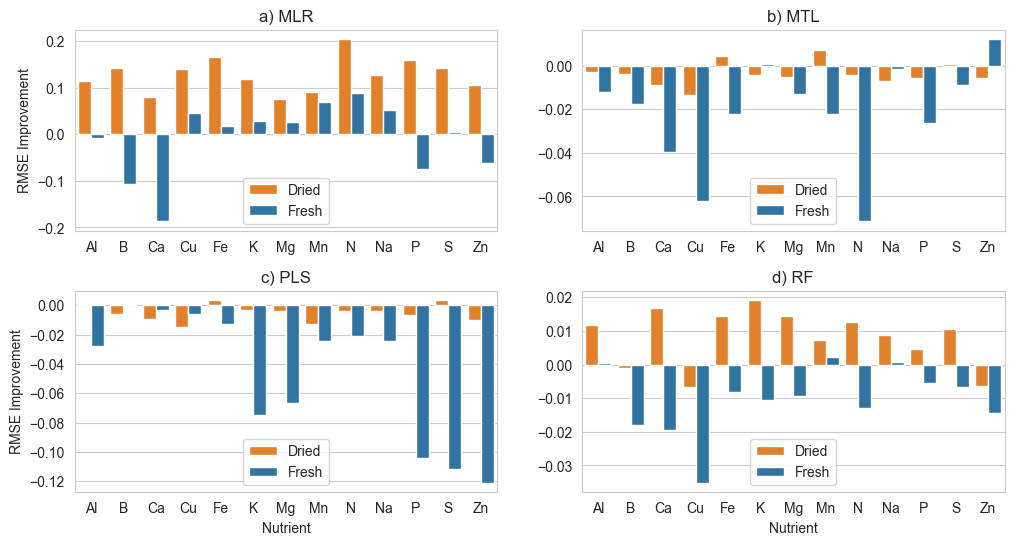

In [125]:
all_dfs = {'mlr':df_bl_rmse, 'mtl':df_mtl_rmse, 'pls':df_pls_rmse, 'rf':df_rf_rmse}
labels = [([0,0],'a) '), ([0,1],'b) '), ([1,0],'c) '), ([1,1],'d) ')]
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=False, sharey=False)
for i, (model_name, d) in enumerate(all_dfs.items()):
    x = i//2
    y = i%2
    ax = axes[x, y]
    sns.barplot(d, x='element', y='improvement', hue='sample_mode', dodge=True, ax=ax, palette=colours)
    label = [label[1] for label in labels if label[0] == [x,y]][0]
    ax.set_title(label + model_name.upper())
    if x == 1:
        ax.set_xlabel('Nutrient')
    else:
        ax.set_xlabel(None)
    if y == 1:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('RMSE Improvement')
    ax.legend(title=None, loc='lower center')

fig.subplots_adjust(hspace=0.3)
plt.savefig(f'{plots_path}/improvement_all_models.png',dpi=400, bbox_inches='tight')
plt.show()

# wRMSE Comparison

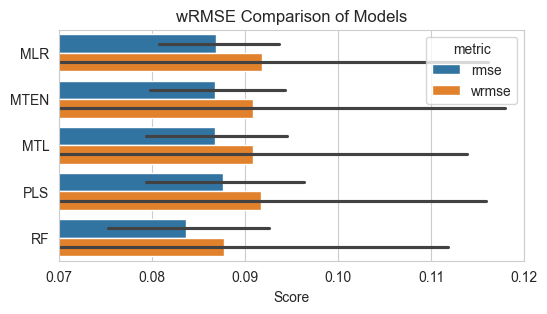

In [126]:
df_wrmse = (dfl[dfl['metric'].isin(['wrmse','rmse'])].
           pivot(index=['model','element','metric'], columns='sample_mode', values='score'))

def add_values(ax):
    for p in ax.patches:
        w = p.get_width()
        ax.annotate(
            f'{w:.4f}',
            (0.22, p.get_y() + p.get_height() / 1.7),
            ha='left',
            va='bottom',
            color='white')

_, ax = plt.subplots(figsize=(6,3))
ax = sns.barplot(df_wrmse, x='Dried', y='model', hue='metric', dodge=True)
plt.title('wRMSE Comparison of Models')
plt.xlabel('Score')
plt.ylabel(None)
plt.xlim(0.07,0.12)
add_values(ax)
plt.show()

# Comparison with previous study
Here we look to prove/disprove the results of the previous study. We will look at the following:
Macro:
- S gave the highest r value in the fresh testing mode
- A comparable result was given by Lasso MLR for S with close r2 value in both modes
- P and K were given highest r values in the dried testing mode
- Lasso MLR also gave indistinguishable r2 values in both modes.
- In contrast to Pearson 's correlation, Lasso MLR training model showed that  N has highest r2 values for the fresh testing model
- The most significant wavebands were in the Vis range for N, P and C , except for one waveband found in the NIR range for K, Mg and S which might possibly be related to the synergistic effect among them
- The significant wavebands in Vis range would probably explain having the highest correlation in fresh testing mode for N and K, in addition to P, and S as those wavebands will not interfere with water absorbance spectra in the NIR range.

Micro:
- Micro show highest r values in dried testing except Fe (comparable in both)

In [127]:
# Selects all the rows with the maximum r2 value for each combination of type, sample_mode, and element
result = df[~df['model'].isin(['MTL','MTEN'])].reset_index(drop=True).copy()

def type_mode_df(df):
    result = df.loc[df.groupby(['type', 'sample_mode', 'element'])['r2'].idxmax()].copy()
    result = result[['type', 'element', 'sample_mode', 'r2', 'model']]
    result = result.reset_index(drop=True)
    result['type-mode'] = result['type'] + '-' + result['sample_mode'].apply(lambda x: str.lower(x))
    result.sort_values(by=['type-mode', 'model'], ascending=[True, True], inplace=True)
    return result

result_no_mtl = type_mode_df(df[~df['model'].isin(['MTL','MTEN'])].reset_index(drop=True))
result_with_mtl = type_mode_df(df)

result = result.loc[result.groupby(['type', 'sample_mode', 'element'])['r2'].idxmax()]
result = result[['type', 'element', 'sample_mode', 'r2', 'model']]
result = result.reset_index(drop=True)
result['type-mode'] = result['type'] + '-' + result['sample_mode'].apply(lambda x: str.lower(x))
result.sort_values(by=['type-mode', 'model'], ascending=[True, True], inplace=True)

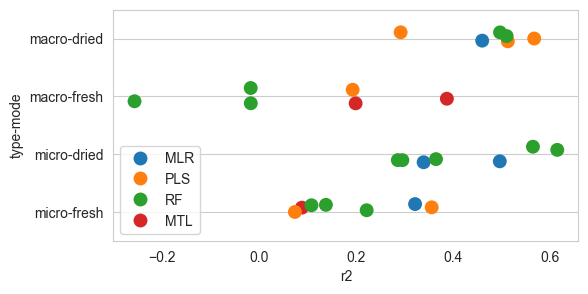

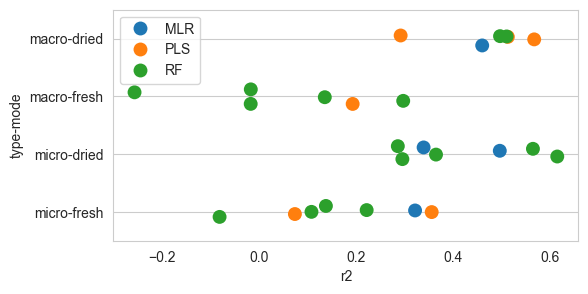

In [128]:
fig, ax = plt.subplots(figsize=(6,3))
sns.stripplot(result_with_mtl, y='type-mode', x='r2', hue='model', jitter=0.15, legend=True, ax=ax, s=10)
plt.grid()
plt.legend(title=None)
plt.show()

fig, ax = plt.subplots(figsize=(6,3))
sns.stripplot(result_no_mtl, y='type-mode', x='r2', hue='model', jitter=0.15, legend=True, ax=ax, s=10)
plt.grid()
plt.legend(title=None)
plt.show()

The above shows greater variance and ranges for combinations of nutrient type and sample mode. This can be seen in the following table:

In [129]:
result.groupby(['type', 'sample_mode']).agg({'r2':'std'}).reset_index()

,type,sample_mode,r2
0,macro,Dried,0.095382
1,macro,Fresh,0.196006
2,micro,Dried,0.134052
3,micro,Fresh,0.151338


Back to the original question, we can see that the results of the previous study are not replicated in this study. The following table shows the top 3 nutrients for each sample mode and type.

In [130]:
top_three = (
    result.groupby('type-mode', group_keys=False)
    .apply(lambda group: group.nlargest(3, 'r2'))
)

# Reset index for a clean output
top_three = top_three.reset_index(drop=True).set_index(['type-mode','element']).drop(columns=['type', 'sample_mode'])
top_three

r2 model
type-mode   element              
macro-dried K        0.5673   PLS
            Mg       0.5129   PLS
            Ca       0.5104    RF
macro-fresh Mg       0.2970    RF
            Ca       0.1927   PLS
            K        0.1352    RF
micro-dried B        0.6149    RF
            Al       0.5647    RF
            Mn       0.4963   MLR
micro-fresh B        0.3558   PLS
            Mn       0.3215   MLR
            Na       0.2216    RF

In [131]:
bottom_three = (
    result.groupby('type-mode', group_keys=False)
    .apply(lambda group: group.nsmallest(3, 'r2'))
)

# Reset index for a clean output
bottom_three = bottom_three.reset_index(drop=True).set_index(['type-mode','element']).drop(columns=['type', 'sample_mode'])
bottom_three

r2 model
type-mode   element              
macro-dried S        0.2917   PLS
            N        0.4600   MLR
            P        0.4968    RF
macro-fresh S       -0.2574    RF
            N       -0.0177    RF
            P       -0.0175    RF
micro-dried Zn       0.2859    RF
            Fe       0.2953    RF
            Cu       0.3391   MLR
micro-fresh Zn      -0.0819    RF
            Cu       0.0735   PLS
            Al       0.1077    RF

- S gave the highest r value in the fresh testing mode
- A comparable result was given by Lasso MLR for S with close r2 value in both modes

The Pearson correlation wasn't measured in our study, but the R2 score for S was the poorest performing nutrient in the dried testing mode, and the second poorest in the fresh testing mode ranked over all models. This is not consistent with the previous study. However, S did show a relatively low error (RMSE=0.0842) despite its poor $R^2$ score with RF, which further reinforces the idea that this model is leveraging non-linear relationships given that the $R^2$ score reflects the linearity of the model.

In [132]:
cols = ['model','sample_mode','element','type','r2','rmse']
df[cols].query('element=="S"')

,model,sample_mode,element,type,r2,rmse
11,MLR,Dried,S,macro,0.2311,0.0949
24,MLR,Fresh,S,macro,-2.6560,0.1437
37,MTL,Dried,S,macro,0.2170,0.0958
50,MTL,Fresh,S,macro,-0.9827,0.1058
63,MTEN,Dried,S,macro,0.2170,0.0958
76,MTEN,Fresh,S,macro,-0.9827,0.1058
89,PLS,Dried,S,macro,0.2917,0.0911
102,PLS,Fresh,S,macro,-7.2371,0.2156
115,RF,Dried,S,macro,0.2742,0.0922
128,RF,Fresh,S,macro,-0.2574,0.0842



- P and K were given highest r values in the dried testing mode

While the other study showed P and K having the highest r values in dried testing, this didn't necessarily relate high R2 score in our study. K did provide a more accurate R2 in the dried mode (0.57 with PLSR) though in fresh had mediocre performance relative to other nutrients, and P was the third poorest R2 (-0.02, output from RF) in the fresh testing mode.

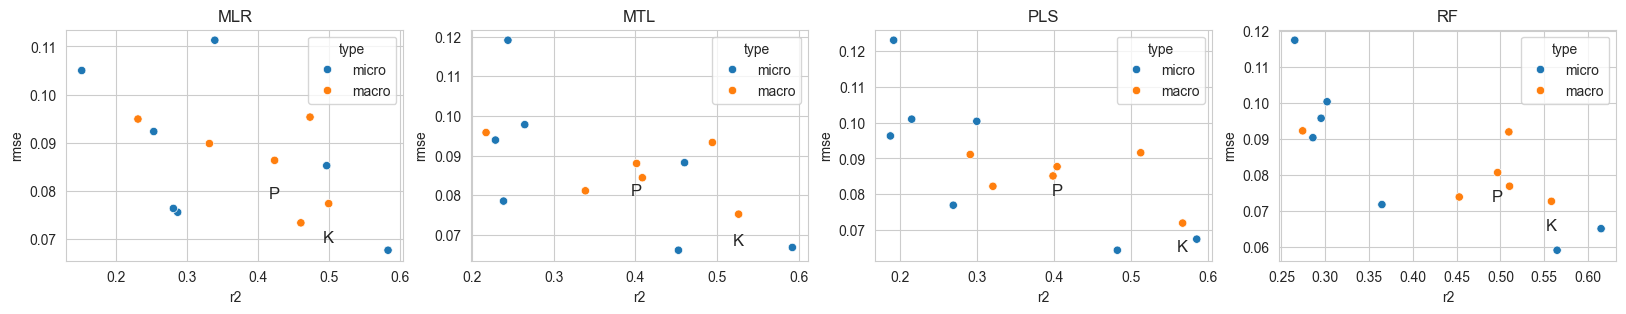

In [133]:
fig,ax = plt.subplots(figsize=(20,3), ncols=4)
df_dried = df[cols].query('sample_mode=="Dried" and model!="MTEN"')
models = df_dried['model'].unique()


for i, m in enumerate(models):
    df_temp = df_dried.query('model==@m')
    sns.scatterplot(df_temp, x='r2', y='rmse', hue='type', ax=ax[i])
    ax[i].set_title(m)
    for x, row in df_temp.iterrows():
        if row['element'] in ['P','K']:
            ax[i].text(row['r2'], row['rmse'] - 0.008, row['element'], ha='center', fontsize=12)

plt.show()



- The most significant wavebands were in the Vis range for N, P and C , except for one waveband found in the NIR range for K, Mg and S which might possibly be related to the synergistic effect among them

- In contrast to Pearson 's correlation, Lasso MLR training model showed that  N has highest r2 values for the fresh testing model
- The significant wavebands in Vis range would probably explain having the highest correlation in fresh testing mode for N and K, in addition to P, and S as those wavebands will not interfere with water absorbance spectra in the NIR range.

	Micro:
Micro show highest r values in dried testing except Fe (comparable in both)

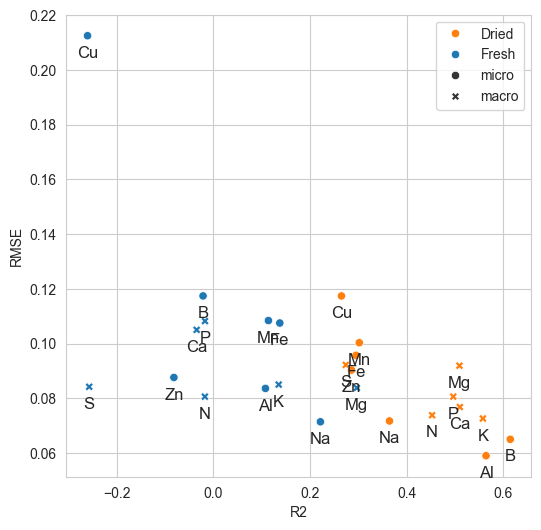

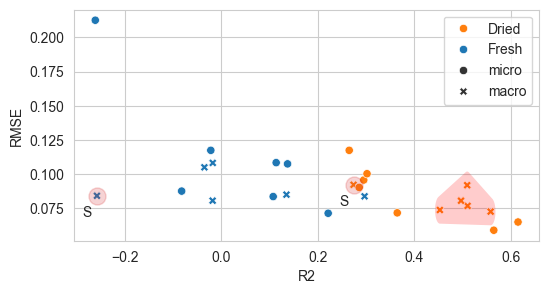

In [134]:
df_rf_score_compare = dfl.query('model=="RF" and metric.isin(["r2","rmse"])').pivot(columns='metric', index=['sample_mode','element','type'], values='score').reset_index()

fig,ax = plt.subplots(figsize=(6,6))
sns.scatterplot(df_rf_score_compare, x='r2', y='rmse', hue='sample_mode', style='type', palette=colours, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[i] for i in [1,2,4,5]], [labels[i] for i in [1,2,4,5]])
ax.set_ylabel('RMSE')
ax.set_xlabel('R2')
for i, row in df_rf_score_compare.iterrows():
    ax.text(row['r2'], row['rmse'] - 0.008, row['element'], ha='center', fontsize=12)
plt.show()

fig,ax = plt.subplots(figsize=(6,3))
sns.scatterplot(df_rf_score_compare, x='r2', y='rmse', hue='sample_mode', style='type', palette=colours, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[i] for i in [1,2,4,5]], [labels[i] for i in [1,2,4,5]])
ax.set_ylabel('RMSE')
ax.set_xlabel('R2')
# S annotation and highlighting
for i, row in df_rf_score_compare.iterrows():
    if row['element']=='S':
        ax.text(row['r2']-0.02, row['rmse'] - 0.015, 'S', ha='center', fontsize=10)
        ax.scatter(row['r2'], row['rmse'], s=150, color='C3', marker='o', alpha=0.2, label='S highlight')

# Macro nutrient cluster highlighting
points = (df_rf_score_compare.
          query('r2>0.4 and type=="macro"').
          drop(columns=['sample_mode','type','element']).
          to_numpy())
alpha = 0.001
alpha_shape = alphashape.alphashape(points, alpha)
buffer_distance = 0.01
buffered_shape = alpha_shape.buffer(buffer_distance)
if isinstance(buffered_shape, Polygon):
    x, y = buffered_shape.exterior.xy
    plt.fill(x, y, color='red', alpha=0.2, edgecolor='red', linewidth=0)
else:
    for polygon in buffered_shape.geoms:
        x, y = polygon.exterior.xy
        plt.fill(x, y, color='red', alpha=0.2, edgecolor='red', linewidth=0)

plt.savefig(f'{plots_path}/RF_R2_RMSE.png', dpi=400, bbox_inches='tight')
plt.show()